<a href="https://colab.research.google.com/github/mainak555/lb-ai/blob/ai/Assignment02_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hey fellas,

Welcome to second asignment series. Here we are gonna use Backprop to correct errors. The first task is to go through this complete code and understand its working.  Then go at the end of code and see the XOR implementation. Something is missing over there. Try to rectify the code( either augment the given code or write your own). Also mention what was missing  though in a text box. I would appreciate

#### Ans: As it's a XOR instead Sigmoid Tanh is better. Hence added tanh along the derivative to Neuron Class

In [0]:
import random
import math
import numpy as np

In [0]:
class NeuralNetwork:
    LEARNING_RATE = 0.05

    def __init__(self, num_inputs, num_hidden, num_outputs, hidden_layer_weights = None, hidden_layer_bias = None, output_layer_weights = None, output_layer_bias = None):
        self.num_inputs = num_inputs

        self.hidden_layer = NeuronLayer(num_hidden, hidden_layer_bias)
        self.output_layer = NeuronLayer(num_outputs, output_layer_bias)

        self.init_weights_from_inputs_to_hidden_layer_neurons(hidden_layer_weights)
        self.init_weights_from_hidden_layer_neurons_to_output_layer_neurons(output_layer_weights)

    def init_weights_from_inputs_to_hidden_layer_neurons(self, hidden_layer_weights):
        weight_num = 0
        for h in range(len(self.hidden_layer.neurons)):
            for i in range(self.num_inputs):
                if not hidden_layer_weights:
                    self.hidden_layer.neurons[h].weights.append(random.random())
                else:
                    self.hidden_layer.neurons[h].weights.append(hidden_layer_weights[weight_num])
                weight_num += 1

    def init_weights_from_hidden_layer_neurons_to_output_layer_neurons(self, output_layer_weights):
        weight_num = 0
        for o in range(len(self.output_layer.neurons)):
            for h in range(len(self.hidden_layer.neurons)):
                if not output_layer_weights:
                    self.output_layer.neurons[o].weights.append(random.random())
                else:
                    self.output_layer.neurons[o].weights.append(output_layer_weights[weight_num])
                weight_num += 1
                
    def inspect(self):
        print('------')
        print('* Inputs: {}'.format(self.num_inputs))
        print('------')
        print('Hidden Layer')
        self.hidden_layer.inspect()
        print('------')
        print('* Output Layer')
        self.output_layer.inspect()
        print('------')

    def feed_forward(self, inputs):
        hidden_layer_outputs = self.hidden_layer.feed_forward(inputs)
        return self.output_layer.feed_forward(hidden_layer_outputs)
      
    
    # Uses online learning, ie updating the weights after each training case
    def train(self, training_inputs, training_outputs):
        self.feed_forward(training_inputs)

        # 1. Output neuron deltas
        pd_errors_wrt_output_neuron_total_net_input = [0] * len(self.output_layer.neurons)
        for o in range(len(self.output_layer.neurons)):

            # ∂E/∂zⱼ
            pd_errors_wrt_output_neuron_total_net_input[o] = self.output_layer.neurons[o].calculate_pd_error_wrt_total_net_input(training_outputs[o])

        # 2. Hidden neuron deltas
        pd_errors_wrt_hidden_neuron_total_net_input = [0] * len(self.hidden_layer.neurons)
        for h in range(len(self.hidden_layer.neurons)):

            # We need to calculate the derivative of the error with respect to the output of each hidden layer neuron
            # dE/dyⱼ = Σ ∂E/∂zⱼ * ∂z/∂yⱼ = Σ ∂E/∂zⱼ * wᵢⱼ
            d_error_wrt_hidden_neuron_output = 0
            for o in range(len(self.output_layer.neurons)):
                d_error_wrt_hidden_neuron_output += pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].weights[h]

            # ∂E/∂zⱼ = dE/dyⱼ * ∂zⱼ/∂
            pd_errors_wrt_hidden_neuron_total_net_input[h] = d_error_wrt_hidden_neuron_output * self.hidden_layer.neurons[h].calculate_pd_total_net_input_wrt_input()

        # 3. Update output neuron weights
        for o in range(len(self.output_layer.neurons)):
            for w_ho in range(len(self.output_layer.neurons[o].weights)):

                # ∂Eⱼ/∂wᵢⱼ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢⱼ
                pd_error_wrt_weight = pd_errors_wrt_output_neuron_total_net_input[o] * self.output_layer.neurons[o].calculate_pd_total_net_input_wrt_weight(w_ho)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.output_layer.neurons[o].weights[w_ho] -= self.LEARNING_RATE * pd_error_wrt_weight

        # 4. Update hidden neuron weights
        for h in range(len(self.hidden_layer.neurons)):
            for w_ih in range(len(self.hidden_layer.neurons[h].weights)):

                # ∂Eⱼ/∂wᵢ = ∂E/∂zⱼ * ∂zⱼ/∂wᵢ
                pd_error_wrt_weight = pd_errors_wrt_hidden_neuron_total_net_input[h] * self.hidden_layer.neurons[h].calculate_pd_total_net_input_wrt_weight(w_ih)

                # Δw = α * ∂Eⱼ/∂wᵢ
                self.hidden_layer.neurons[h].weights[w_ih] -= self.LEARNING_RATE * pd_error_wrt_weight
                
                
    def calculate_total_error(self, training_sets):
        total_error = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                total_error += self.output_layer.neurons[o].calculate_error(training_outputs[o])
        return total_error



In [0]:
class NeuronLayer:
    def __init__(self, num_neurons, bias):

        # Every neuron in a layer shares the same bias
        self.bias = bias if bias else random.random()

        self.neurons = []
        for i in range(num_neurons):
            self.neurons.append(Neuron(self.bias))

    def inspect(self):
        print('Neurons:', len(self.neurons))
        for n in range(len(self.neurons)):
            print(' Neuron', n)
            for w in range(len(self.neurons[n].weights)):
                print('  Weight:', self.neurons[n].weights[w])
            print('  Bias:', self.bias)

    def feed_forward(self, inputs):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.calculate_output(inputs))
        return outputs

    def get_outputs(self):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.output)
        return outputs

In [0]:
class Neuron:
    sqashing_fn = ['sigmoid', 'tanh', 'arctan']
    selected_squash = sqashing_fn[0]
    def __init__(self, bias):
        self.bias = bias
        self.weights = []

    def calculate_output(self, inputs):        
        self.inputs = inputs
        self.output = self.squash(self.calculate_total_net_input())
        return self.output

    def calculate_total_net_input(self):
        total = 0
        for i in range(len(self.inputs)):
            total += self.inputs[i] * self.weights[i]
        return total + self.bias

    # Apply the logistic function to squash the output of the neuron
    def squash(self, total_net_input):
        if Neuron.selected_squash == Neuron.sqashing_fn[1]:
            return (2 / (1+math.exp(-2*total_net_input))) - 1       #Tanh
        # elif Neuron.selected_squash == self.sqashing_fn[2]:
        #     return np.arctan(total_net_input)                       #ArcTan
        else:   #sqashing_fn[0]
            return 1 / (1 + math.exp(-total_net_input))             #sigmoid

    #%% [markdown]
    # Determine how much the neuron's total input has to change to move closer to the expected output
    #
    # Now that we have the partial derivative of the error with respect to the output (∂E/∂yⱼ) and
    # the derivative of the output with respect to the total net input (dyⱼ/dzⱼ) we can calculate
    # the partial derivative of the error with respect to the total net input.
    # This value is also known as the delta (δ) [1]
    # δ = ∂E/∂zⱼ = ∂E/∂yⱼ * dyⱼ/dzⱼ
    #
    def calculate_pd_error_wrt_total_net_input(self, target_output):
        return self.calculate_pd_error_wrt_output(target_output) * self.calculate_pd_total_net_input_wrt_input();

    # The error for each neuron is calculated by the Mean Square Error method:
    def calculate_error(self, target_output):
        return 0.5 * (target_output - self.output) ** 2

    # The partial derivate of the error with respect to actual output then is calculated by:
    # = 2 * 0.5 * (target output - actual output) ^ (2 - 1) * -1
    # = -(target output - actual output)
    #
    # The Wikipedia article on backpropagation [1] simplifies to the following, but most other learning material does not [2]
    # = actual output - target output
    #
    # Alternative, you can use (target - output), but then need to add it during backpropagation [3]
    #
    # Note that the actual output of the output neuron is often written as yⱼ and target output as tⱼ so:
    # = ∂E/∂yⱼ = -(tⱼ - yⱼ)
    def calculate_pd_error_wrt_output(self, target_output):
        return -(target_output - self.output)

    # The total net input into the neuron is squashed using logistic function to calculate the neuron's output:
    # yⱼ = φ = 1 / (1 + e^(-zⱼ))
    # Note that where ⱼ represents the output of the neurons in whatever layer we're looking at and ᵢ represents the layer below it
    #
    # The derivative (not partial derivative since there is only one variable) of the output then is:
    # dyⱼ/dzⱼ = yⱼ * (1 - yⱼ)
    def calculate_pd_total_net_input_wrt_input(self):
        if Neuron.selected_squash == Neuron.sqashing_fn[1]:
            return 1 - np.square(self.output)               #derivative of Tanh
        # elif Neuron.selected_squash == self.sqashing_fn[2]:
        #     return 1 / (1 + np.square(self.output))
        else:
            return self.output * (1 - self.output)         #derivative of Sigmoid

    # The total net input is the weighted sum of all the inputs to the neuron and their respective weights:
    # = zⱼ = netⱼ = x₁w₁ + x₂w₂ ...
    #
    # The partial derivative of the total net input with respective to a given weight (with everything else held constant) then is:
    # = ∂zⱼ/∂wᵢ = some constant + 1 * xᵢw₁^(1-0) + some constant ... = xᵢ
    def calculate_pd_total_net_input_wrt_weight(self, index):
        return self.inputs[index]

In [11]:
# Example 1

nn = NeuralNetwork(2, 2, 2, hidden_layer_weights=[0.15, 0.2, 0.25, 0.3], hidden_layer_bias=0.35, output_layer_weights=[0.4, 0.45, 0.5, 0.55], output_layer_bias=0.6)
for i in range(10000):
    nn.train([0.05, 0.1], [0.01, 0.99])
    print(i, round(nn.calculate_total_error([[[0.05, 0.1], [0.01, 0.99]]]), 9))


0 0.297639963
1 0.29690735
2 0.296173281
3 0.295437769
4 0.294700824
5 0.29396246
6 0.293222689
7 0.292481524
8 0.291738978
9 0.290995064
10 0.290249795
11 0.289503187
12 0.288755252
13 0.288006005
14 0.287255461
15 0.286503634
16 0.285750539
17 0.284996193
18 0.284240609
19 0.283483804
20 0.282725795
21 0.281966596
22 0.281206226
23 0.2804447
24 0.279682035
25 0.278918249
26 0.27815336
27 0.277387384
28 0.27662034
29 0.275852246
30 0.275083121
31 0.274312982
32 0.273541849
33 0.272769742
34 0.271996678
35 0.271222678
36 0.270447761
37 0.269671948
38 0.268895259
39 0.268117713
40 0.267339332
41 0.266560137
42 0.265780148
43 0.264999386
44 0.264217873
45 0.263435631
46 0.262652682
47 0.261869047
48 0.261084749
49 0.260299809
50 0.259514251
51 0.258728098
52 0.257941372
53 0.257154096
54 0.256366294
55 0.255577988
56 0.254789204
57 0.253999964
58 0.253210292
59 0.252420212
60 0.251629749
61 0.250838927
62 0.25004777
63 0.249256303
64 0.248464551
65 0.247672538
66 0.246880291
67 0.2460878

In [12]:
# XOR example - Homework. Correct the implemnation to run XOR problem with higher accuracy, Mention whats missing:

training_sets = [
    [[0, 0], [0]],
    [[0, 1], [1]],
    [[1, 0], [1]],
    [[1, 1], [0]]
]
N = 10000
training_inputs = np.zeros((N,2)) 
training_outputs = np.zeros((N,1))
out_err = np.zeros((N,2))

print('Squashing fn[{}] Err: '.format(Neuron.selected_squash))
nn = NeuralNetwork(len(training_sets[0][0]), 5, len(training_sets[0][1]))
for i in range(N):
    training_inputs[i], training_outputs[i] = random.choice(training_sets)
    nn.train(training_inputs[i], training_outputs[i])
    #print(i, nn.calculate_total_error(training_sets))
    out_err[i][0] = nn.calculate_total_error(training_sets)
print(out_err[i][0])

Squashing fn[sigmoid] Err: 
0.49509048256199756


In [13]:
Neuron.selected_squash = Neuron.sqashing_fn[1]
print('Squashing fn[{}] Err: '.format(Neuron.selected_squash))
nn2 = NeuralNetwork(len(training_sets[0][0]), 5, len(training_sets[0][1]))
for i in range(N):
    nn.train(training_inputs[i], training_outputs[i])
    #print(i, nn.calculate_total_error(training_sets))
    out_err[i][1] = nn.calculate_total_error(training_sets)
print(out_err[i][1])

Squashing fn[tanh] Err: 
0.0009360268985356684


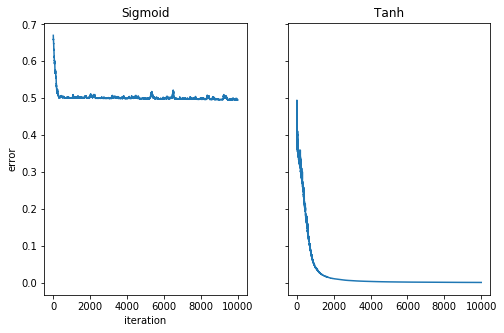

In [16]:
import matplotlib.pyplot as plt
i = range(0, 10000, 1)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 5))
ax1.plot(i, out_err[:,:1])
ax1.set_title('Sigmoid')
ax1.set_ylabel('error')
ax1.set_xlabel('iteration')
ax2.plot(i, out_err[:,1:])
ax2.set_title('Tanh')
plt.show()